## New York City Airbnb Data Exploration

***

Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present more unique, personalized way of experiencing the world. This dataset describes the listing activity and metrics in NYC, NY for 2019.
This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions.<br>

The goal of this notebook is to gain a basic understanding about the distributions across the listing features and to extract simple metrics about the data set as a whole.

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import urllib

In [46]:
data = pd.read_csv('AB_NYC_2019.csv')

In [47]:
data.columns
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Examining our Data 

***

The first feature of the data I noticed is that the only information provided regarding each listing's size is a 'room_type' categorical feature. My initial intuition is that having a continuous feature value of say 'square_footage' would most likely improve any predictive modeling with regards to price per night.

##### Data integrity:

Check the data for null and zero values as these values will hinder or skew some of the calculations that follow 


In [48]:
print(data.isnull().sum())

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


As shown above, we can see that this dataset was most likely already cleaned to some degree as there's almost no null values in the dataset with the exception of columns 'last_review' and 'reviews_per_month'.<br>

The null values that we do have are contained in 'name', 'host_name', 'last_review', and 'reviews_per_month' two of which the total number of null values is very small (16 and 21) but also columns that contain data I do not intend to look into. Sorry I don't want to look in the most common first name of a typical airbnb host :)

The null values for last_review and reviews_per_month can be explained by looking at the sum of zero values across the various columns

In [49]:
df_zeros = pd.DataFrame({})
for column_name in data.columns:
    column = data[column_name]
    count = (column == 0).sum()
    df_zeros.insert(len(df_zeros.columns), column_name, [count])

df_zeros

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,0,0,0,0,0,0,0,0,0,11,0,10052,0,0,0,17533


Looking at the number of zero values in 'number_of_reviews' we can see that there also exists 10052 airbnb's with zero reviews, explaining the 10052 null values for 'last_review' and 'reviews_per_month' <br>

There also exists 11 listings in the data set that have a 'price' of zero dollars. We'll make the assumption these are not free accommodations and treat them as outliers, removing them from the dataset.

<font color = 'gray'>

To Do: Replace the prices for the listings whose price is currently zero with the average price for the neighbourhood and accommodations type the listings reside in

In [50]:
data.drop(data[data['price'] == 0].index, inplace = True)
data.reset_index(drop = True, inplace=True)

Safe to say this dataset was precleaned in the CSV provided

### Data Distributions
***

#### Geographical Distributions

Each Airbnb listing has two categorical features, 'neighbourhood_group' and 'neighbourhood', with respect to the listings geographical location

* neighbourhood_group: Consists of the five NY Boroughs (Manhattan, Brooklyn, Queens, Bronx and Staten Island)
* neighbourhood: Consists of 221 unique neighbourhoods within the five boroughs

Below we have plotted a bar plot to look at the data distributions between the 'neighbourhood_group' classes

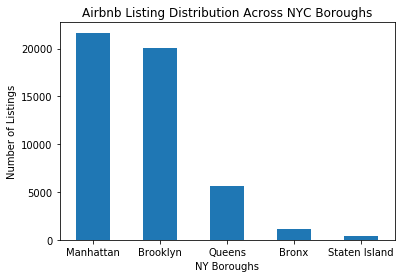

,Number of Listings,Percentage of Total Listings
Manhattan,21660,44.31
Brooklyn,20095,41.11
Queens,5666,11.59
Bronx,1090,2.23
Staten Island,373,0.76


In [51]:
data['neighbourhood_group'].value_counts().plot(kind='bar')
plt.title('Airbnb Listing Distribution Across NYC Boroughs')
plt.xlabel('NY Boroughs') 
plt.ylabel('Number of Listings')
plt.xticks(rotation = 0)
plt.show()

listings_per_borough = (data['neighbourhood_group'].value_counts())
percent_listings_per_borough = (data['neighbourhood_group'].value_counts(normalize = True) * 100)

geo_distribution_df = pd.concat([listings_per_borough, percent_listings_per_borough], axis=1)
geo_distribution_df.set_axis(['Number of Listings', 'Percentage of Total Listings'], axis=1, inplace=True)
geo_distribution_df.round(2)

As shown above in the table, approximately 97% of all listings are within three of the five NYC boroughs (Manhattan, Brooklyn, and Queens)

####  Accommodation Type Distribution

This section will look at how the accommodation types are distributed across the five NYC boroughs 

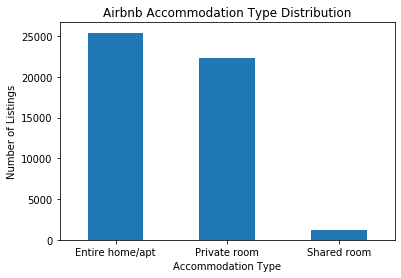

,NY Borough,Entire Home/Apartment Totals,Private Room Totals,Shared Room Totals
0,Bronx,379,651,60
1,Brooklyn,9558,10126,411
2,Manhattan,13198,7982,480
3,Queens,2096,3372,198
4,Staten Island,176,188,9


In [52]:
grouped_entire_homes = data[data['room_type'] == 'Entire home/apt'].groupby('neighbourhood_group').size()
grouped_private_room = data[data['room_type'] == 'Private room'].groupby('neighbourhood_group').size()
grouped_shared_room = data[data['room_type'] == 'Shared room'].groupby('neighbourhood_group').size()

room_type_totals = {'Entire Home/Apartment Totals': grouped_entire_homes, 
    'Private Room Totals': grouped_private_room,
    'Shared Room Totals': grouped_shared_room}

grouped_accommodation_df = pd.concat(room_type_totals, axis = 1)
grouped_accommodation_df.reset_index(inplace=True)
grouped_accommodation_df.rename(columns={'neighbourhood_group': 'NY Borough'}, inplace=True)

data['room_type'].value_counts().plot(kind='bar')
plt.title('Airbnb Accommodation Type Distribution')
plt.xlabel('Accommodation Type') 
plt.ylabel('Number of Listings')
plt.xticks(rotation = 0)
plt.show()

grouped_accommodation_df

#### Accommodation Pricing

This section will look at the cost of accommodation in the NYC Airbnb market with respect to the location and type of accommodation

Looking at the average price per night of the three accommodation types offered

,room_type,Average_Cost
0,Entire home/apt,211.81
1,Private room,89.81
2,Shared room,70.25


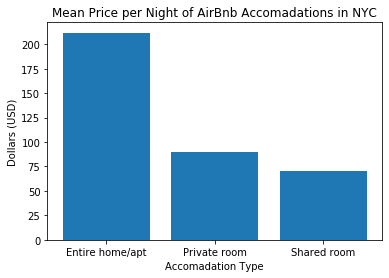

In [53]:
average_accom_type_cost = data.groupby('room_type').agg(Average_Cost = ('price', 'mean'))
average_accom_type_cost.reset_index(inplace=True)

plt.bar(average_accom_type_cost['room_type'], average_accom_type_cost['Average_Cost'])
plt.title('Mean Price per Night of AirBnb Accomadations in NYC')
plt.xlabel('Accomadation Type')
plt.ylabel('Dollars (USD)')

average_accom_type_cost.round(2)  

The average price per night of an entire home/apartment is over $200 per night, more than double and triple the average per night cost of a private room or shared room respectively

#### Accommodation Pricing by Borough

Looking closer at the data, we can break down the average cost per night of each accommodation type based on the neighbourhood group each listing resides in.<br>

We'll also perform outlier filtering on the listings using the 1.5 * IQR rule applied to the listing's price.

Due to the relatively small portion of listings for the boroughs of Staten Island and the Bronx, I've decided we'll omit these from the direct borough accommodation type price comparisons.

In [54]:
# Takes a dataframe of listings, drops listings above and below the min and max thresholds calculated using 1.5 * IQR rule
def filterOutlierPrices(type_of_accom):
    Q1, Q3 = type_of_accom['price'].quantile([0.25,0.75])
    IQR = Q3 - Q1
    min_threshold = Q1 - 1.5 * IQR
    max_threshold = Q3 + 1.5 * IQR
    type_of_accom = type_of_accom[(type_of_accom['price'] < min_threshold) | (type_of_accom['price'] < max_threshold)]
    return type_of_accom

# Takes a room type and neighbourhood group, returning all listings matching these parameters
def subset_costs(room_type, neigh_group):
    neighbour_accom = data.loc[(data['room_type'] == room_type) & (data['neighbourhood_group'] == neigh_group)]
    return neighbour_accom

,Manhattan Prices,Manhattan Prices Filtered,Brooklyn Prices,Brooklyn Prices Filtered,Queens Prices,Queens Prices Filtered
Entire Home/Apartment,249.26,195.35,178.35,148.30,147.05,127.18
Private Room,116.78,89.80,76.55,64.19,71.76,60.04
Shared Room,88.98,65.73,50.77,37.04,69.02,38.61


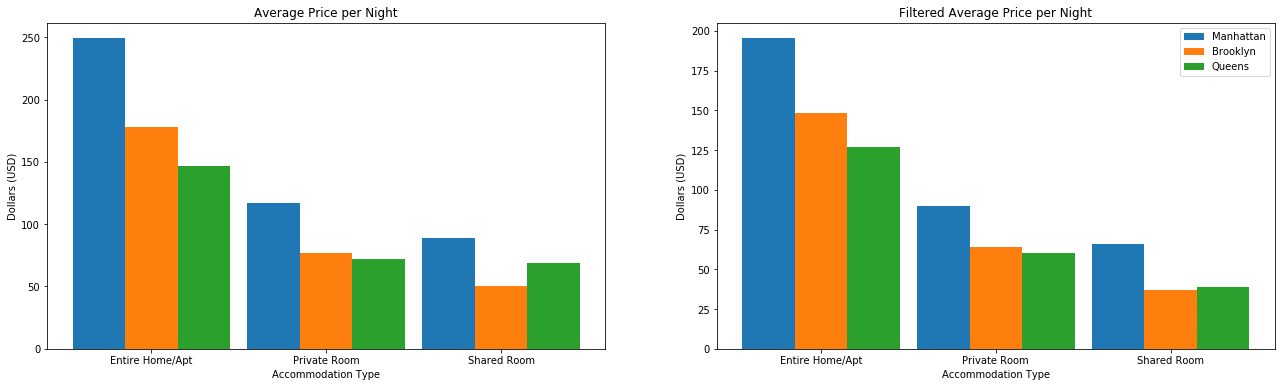

In [71]:
manhattan_prices, brooklyn_prices, queens_prices, bronx_prices, staten_prices = [], [], [], [], []
manhattan_prices_filtered, brooklyn_prices_filtered, queens_prices_filtered, bronx_prices_filtered, staten_prices_filtered  = [], [], [], [], []
rental_accommodations = ['Entire Home/Apt', 'Private Room', 'Shared Room']
ny_bouroghs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

man_entire_home = subset_costs('Entire home/apt', 'Manhattan')
man_private = subset_costs('Private room', 'Manhattan')
man_shared = subset_costs('Shared room', 'Manhattan')
brook_entire_home = subset_costs('Entire home/apt', 'Brooklyn')
brook_private = subset_costs('Private room', 'Brooklyn')
brook_shared = subset_costs('Shared room', 'Brooklyn') 
queen_entire_home = subset_costs('Entire home/apt', 'Queens')
queen_private = subset_costs('Private room', 'Queens')
queen_shared = subset_costs('Shared room', 'Queens')
bronx_entire_home = subset_costs('Entire home/apt', 'Bronx')
bronx_private = subset_costs('Private room', 'Bronx')
bronx_shared = subset_costs('Shared room', 'Bronx')
staten_entire_home = subset_costs('Entire home/apt', 'Staten Island')
staten_private = subset_costs('Private room', 'Staten Island')
staten_shared = subset_costs('Shared room', 'Staten Island')

man_entire_home_filter = filterOutlierPrices(man_entire_home)
man_private_filter = filterOutlierPrices(man_private)
man_shared_filter = filterOutlierPrices(man_shared)
brook_entire_home_filter = filterOutlierPrices(brook_entire_home)
brook_private_filter = filterOutlierPrices(brook_private)
brook_shared_filter = filterOutlierPrices(brook_shared) 
queen_entire_home_filter = filterOutlierPrices(queen_entire_home)
queen_private_filter = filterOutlierPrices(queen_private )
queen_shared_filter = filterOutlierPrices(queen_shared)
bronx_entire_home_filter = filterOutlierPrices(bronx_entire_home)
bronx_private_filter = filterOutlierPrices(bronx_private )
bronx_shared_filter = filterOutlierPrices(bronx_shared)
staten_entire_home_filter = filterOutlierPrices(staten_entire_home)
staten_private_filter = filterOutlierPrices(staten_private )
staten_shared_filter = filterOutlierPrices(staten_shared)

filtered_data = pd.concat(
    [man_entire_home_filter, man_private_filter, man_shared_filter, 
    brook_entire_home_filter, brook_private_filter, brook_shared_filter,
    queen_entire_home_filter, queen_private_filter, queen_shared_filter,
    bronx_entire_home_filter, brook_private_filter, bronx_shared_filter,
    staten_entire_home_filter, staten_private_filter, staten_shared_filter])
filtered_data.reset_index(drop = True, inplace=True)

manhattan_prices.extend((man_entire_home['price'].mean(), man_private['price'].mean(), man_shared['price'].mean()))
brooklyn_prices.extend((brook_entire_home['price'].mean(), brook_private['price'].mean(), brook_shared['price'].mean()))
queens_prices.extend((queen_entire_home['price'].mean(), queen_private['price'].mean(), queen_shared['price'].mean()))

manhattan_prices_filtered.extend((man_entire_home_filter['price'].mean(), man_private_filter['price'].mean(), man_shared_filter['price'].mean()))
brooklyn_prices_filtered.extend((brook_entire_home_filter['price'].mean(), brook_private_filter['price'].mean(), brook_shared_filter['price'].mean()))
queens_prices_filtered.extend((queen_entire_home_filter['price'].mean(), queen_private_filter['price'].mean(), queen_shared_filter['price'].mean()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,6))
width = 0.3
x_axis = np.arange(len(rental_accommodations))

ax1.bar(np.arange(len(manhattan_prices)), manhattan_prices, width = width, label = "Manhattan")
ax1.bar(np.arange(len(brooklyn_prices)) + width, brooklyn_prices, width = width, label = "Brooklyn")
ax1.bar(np.arange(len(queens_prices)) + width*2, queens_prices, width = width, label = "Queens")

ax2.bar(np.arange(len(manhattan_prices_filtered)), manhattan_prices_filtered, width = width, label = "Manhattan")
ax2.bar(np.arange(len(brooklyn_prices_filtered)) + width, brooklyn_prices_filtered, width = width, label = "Brooklyn")
ax2.bar(np.arange(len(manhattan_prices_filtered)) + width*2, queens_prices_filtered, width = width, label = "Queens")

ax1.title.set_text('Average Price per Night')
ax1.set_xticks(x_axis + width / 1)
ax1.set_xticklabels(rental_accommodations)
ax1.set_xlabel('Accommodation Type')
ax1.set_ylabel('Dollars (USD)')

ax2.title.set_text('Filtered Average Price per Night')
ax2.set_xticks(x_axis + width / 1)
ax2.set_xticklabels(rental_accommodations)
ax2.set_xlabel('Accommodation Type')
ax2.set_ylabel('Dollars (USD)')
plt.legend()

average_price_per_night_df = pd.DataFrame(
    {'Manhattan Prices': manhattan_prices,
     'Manhattan Prices Filtered': manhattan_prices_filtered,
     'Brooklyn Prices': brooklyn_prices,
     'Brooklyn Prices Filtered': brooklyn_prices_filtered,
     'Queens Prices': queens_prices,
     'Queens Prices Filtered': queens_prices_filtered},index=['Entire Home/Apartment', 'Private Room', 'Shared Room']
)
average_price_per_night_df.round(2)

After filtering our listings we see a drop in the average price per night across the three boroughs regardless of accommodation type. 

This would imply one or both of these statements to be true about our filtering, 

* The majority of outliers existed at a price above the Q3 + 1.5 * IQR threshold 
* Outliers that did exist above the threshold had more magnitude or were greater outliers than those whose price was under the minimum price threshold for our outlier filtering. 


In each of the three boroughs regardless of accommodation type we see a distinct increment in the average price from 'Shared Room' to 'Private Room' to 'Entire Home/Apartment' respectively.

The only neighbourhood and accommodation type for which we do not see a district increase in the price is in the unfiltered Queens average price for a 'Shared Room' and a 'Private Room'

In comparison to the Manhattan and Brooklyn boroughs, whose unfiltered listings saw a 31.24 and 50.78 percent respective increase in average price per night going from a 'Shared Room' to a 'Private Room' accommodation, the Queens borough only saw an increase of 3.97 percent going from a 'Shared Room' to a 'Private Room'. 

This could be an indicator that the Queens 'Shared Room' accommodation listings might have some significant outlier listings with regards to price. <br>
Since we filtered the listings, we see the mean price of a Queens 'Shared Room' Listings drop by 44.06 percent of it's original unfiltered mean price per night. This would confirm significant outliers were filtered from the Queens 'Shared Room' listings 


Let's examine what impact our filtering of outliers has had to the mean cost of each accommodation type across all listings

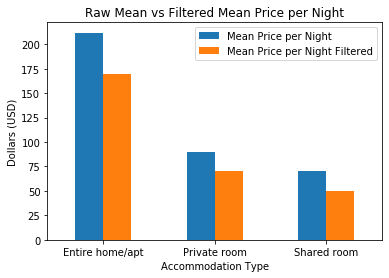

,room_type,Mean Price per Night,Mean Price per Night Filtered
0,Entire home/apt,211.81,169.88
1,Private room,89.81,70.06
2,Shared room,70.25,49.54


In [56]:
average_accom_type_cost_filtered = filtered_data.groupby('room_type').agg(Average_Cost = ('price', 'mean'))
average_accom_type_cost_filtered.reset_index(inplace=True)

average_accom_type_cost_df = pd.merge(average_accom_type_cost, average_accom_type_cost_filtered , on = 'room_type')
average_accom_type_cost_df.rename(columns={'Average_Cost_x': 'Mean Price per Night', 'Average_Cost_y': 'Mean Price per Night Filtered'}, inplace=True)

average_accom_type_cost_df.plot(x="room_type", y=["Mean Price per Night", "Mean Price per Night Filtered"], kind="bar")
plt.title('Raw Mean vs Filtered Mean Price per Night')
plt.xlabel('Accommodation Type') 
plt.ylabel('Dollars (USD)')
plt.xticks(rotation = 0)
plt.show()

average_accom_type_cost_df.round(2)

<font color = 'gray'>

Mean Price vs Filtered Mean Price per Night across all listings after filtering on neighbourhood group and accommodation type groupings

As seen above, the mean price per night across the NYC listings is semi inflated due to the outliers in the data. Once we filter these listings out of the data the mean price per night drops significantly regardless of the accommodation type.

In addition to looking at the average cost of accommodation in the various NYC Boroughs, we can also examine the price among the 221 unique neighbourhoods identified in the data set.

In [57]:
# Creating a dataframe containing all neighbourhoods, the total number of Airbnb listings in each of the neighbourhoods and the average price per night 
neighbourhood_df = data.groupby(['neighbourhood']).agg(Total_Rentals = ('price', 'count'), Average_Cost = ('price', 'mean'))

neighbourhood_grouped = data.groupby('neighbourhood')
neighbourhood_grouped_df = neighbourhood_grouped.apply(lambda x: x['neighbourhood_group'].unique())
neighbourhood_grouped_df = pd.DataFrame(neighbourhood_grouped_df)
neighbourhood_grouped_df.reset_index(inplace=True)
neighbourhood_grouped_df.rename(columns={0: 'Neighbourhood_Group'}, inplace=True)
neighbourhood_grouped_df ['Neighbourhood_Group'] = neighbourhood_grouped_df ['Neighbourhood_Group'].str[0]
neighbourhood_df = pd.merge(neighbourhood_df, neighbourhood_grouped_df , on = 'neighbourhood')
total_neighbourhoods_dropped = neighbourhood_df.loc[neighbourhood_df['Total_Rentals'] < 5, 'neighbourhood'].count()
neighbourhood_df.drop(neighbourhood_df[neighbourhood_df['Total_Rentals'] < 5].index, inplace = True)
neighbourhood_df.reset_index(drop=True, inplace=True)

We now have a dataframe containing neighbourhoods, the total number of Airbnb rentals in each of these neighbourhoods, the average price per night to stay in a given neighbourhood and the borough the neighbourhood resides in.
Neighbourhoods with less than five listings were dropped from the dataframe as these neighbourhoods would have a higher likelihood of being skewed by only one or a few outliers  <br>

As we can see below I grabbed the number of neighbourhoods we disquailified from the least or most expensive neighbourhoods as they did not meet the minimum five listings threshold we set. A total of 26 neighbourhoods contained less than five Airbnb lists and were therefore dropped from the dataframe

In [58]:
total_neighbourhoods_dropped

26

One could argue that the average price per night across neighbourhoods is a misleading representation of the true average price per night. We've already seen across the entire data set to rent an entire home/apt on average has a greater price per night than that of a private room or a shared room. This means that the distribution of accommodation types for each neighbourhood should have a direct impact on the average price per night.  

How do we define the average cost of accommodation for a neighbourhood? 

We can define the average cost per night in a neighbourhood in one of two ways:

1. As the average of all accommodation types across a neighbourhood,
2. Or as the average cost of each accommodation type in each neighbourhood and then take an average of accommodation type averages

Taking an average for each of the accommodation types, and then taking an average across the three accommodation type averages would eliminate any distribution discrepancy among accommodation types between the neighbourhoods. <br> 

The main issue which doesn't make this feasible for all neighbourhoods, is that some neighbourhoods contain very few listing (<10) with some neighbourhoods not containing any listings of a particular accommodation type.

On the other hand one could argue that a higher proportion of 'Entire home/apt' listings compared to the other two accommodation types is a feature of a more expensive neighbourhood and no normalization is needed between the neighbourhood groups.

For the neighbourhood groups, the five NY boroughs, we've calculated the average per night accomodation costs of each accommodation type as each of the


In [59]:
neighbourhood_df.round(2)

# Expand to look at the average cost to stay at each of the three accommodation types, cheapest and most expensive?

# Get the 3 most total rental neighbourhoods from each of the five bouroghs and get the average for the above statement as well as the cheapest and most expensive of each of the three types.

,neighbourhood,Total_Rentals,Average_Cost,Neighbourhood_Group
0,Allerton,42,87.60,Bronx
1,Arrochar,21,115.00,Staten Island
2,Arverne,77,171.78,Queens
3,Astoria,900,117.19,Queens
4,Bath Beach,17,81.76,Brooklyn
...,...,...,...,...
190,Williamsburg,3919,143.84,Brooklyn
191,Windsor Terrace,157,138.99,Brooklyn
192,Woodhaven,88,67.17,Queens
193,Woodlawn,11,60.09,Bronx


In [60]:
cheap_df = neighbourhood_df.nsmallest(10, "Average_Cost").round(2)
expensive_df = neighbourhood_df.nlargest(10, "Average_Cost").round(2)

,neighbourhood,Total_Rentals,Average_Cost,Neighbourhood_Group
24,Bull's Head,6,47.33,Staten Island
91,Hunts Point,18,50.50,Bronx
174,Tremont,11,51.55,Bronx
159,Soundview,15,53.47,Bronx
21,Bronxdale,19,57.11,Bronx
127,New Dorp Beach,5,57.40,Staten Island
80,Grant City,6,57.67,Staten Island
41,Concord,26,58.19,Staten Island
122,Mount Eden,6,58.50,Bronx
45,Corona,64,59.17,Queens


,neighbourhood,Total_Rentals,Average_Cost,Neighbourhood_Group
175,Tribeca,177,490.64,Manhattan
155,Sea Gate,7,487.86,Brooklyn
149,Riverdale,11,442.09,Bronx
5,Battery Park City,70,367.56,Manhattan
69,Flatiron District,80,341.92,Manhattan
144,Randall Manor,19,336.00,Staten Island
129,NoHo,78,295.72,Manhattan
158,SoHo,358,287.10,Manhattan
115,Midtown,1545,282.72,Manhattan
186,West Village,768,267.68,Manhattan


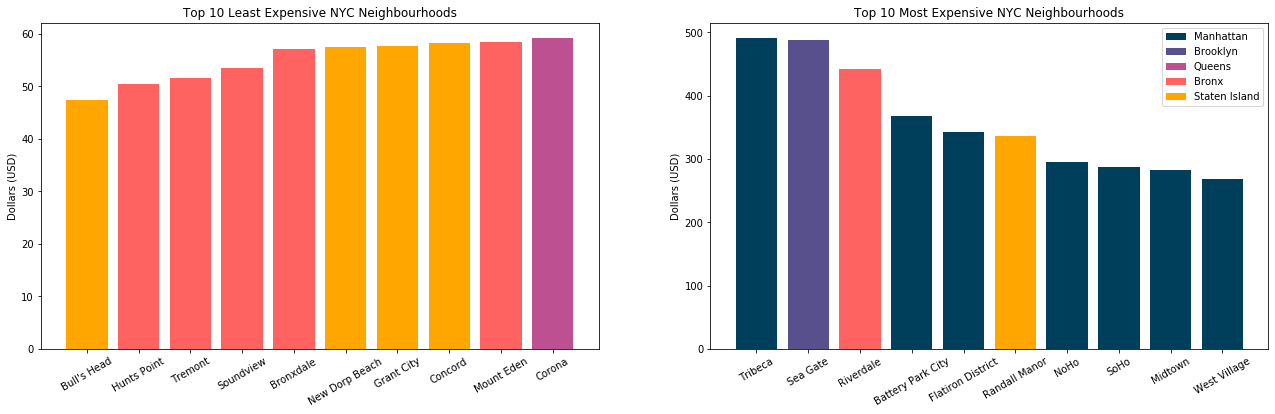

In [61]:
from turtle import color
colours = {"Manhattan": "#003f5c", "Brooklyn": "#58508d", "Queens": "#bc5090", "Bronx": "#ff6361", "Staten Island": "#ffa600"}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,6))

ax1.bar(cheap_df['neighbourhood'], cheap_df['Average_Cost'], color=cheap_df['Neighbourhood_Group'].replace(colours))
ax2.bar(expensive_df['neighbourhood'], expensive_df['Average_Cost'], color=expensive_df['Neighbourhood_Group'].replace(colours))
ax1.title.set_text('Top 10 Least Expensive NYC Neighbourhoods')
ax2.title.set_text('Top 10 Most Expensive NYC Neighbourhoods')
ax1.set_xticklabels(cheap_df['neighbourhood'], rotation = 30)
ax2.set_xticklabels(expensive_df['neighbourhood'], rotation = 30)
ax1.yaxis.set_label_text('Dollars (USD)')
ax2.yaxis.set_label_text('Dollars (USD)')
plt.xticks(rotation = 30)
ax2.legend(
    [Patch(facecolor=colours['Manhattan']),
     Patch(facecolor=colours['Brooklyn']),
     Patch(facecolor=colours['Queens']),
     Patch(facecolor=colours['Bronx']),
     Patch(facecolor=colours['Staten Island'])], ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])

display(cheap_df, expensive_df)

<font color = 'gray'>
Top 10 least and most expensive NYC neighbourhoods on a per night average across all listings within a given neighbourhood

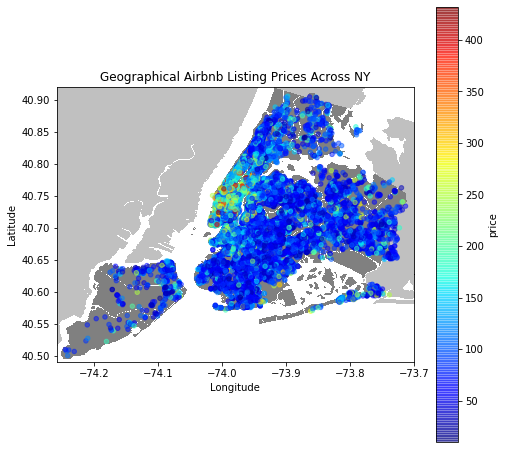

In [62]:
shuffled = filtered_data.sample(frac=1, random_state=1).reset_index()
nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.PNG')
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.70, 40.49,40.92])
ax=plt.gca()

shuffled.plot(kind = 'scatter', x = 'longitude', y = 'latitude', c = 'price', ax = ax, cmap = plt.get_cmap('jet'), colorbar = True, alpha = 0.5, figsize=(8,8))
plt.title('Geographical Airbnb Listing Prices Across NY')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

<font color = 'gray'>

Note:

The above geographical plot of the listings filtered price across the five NY boroughs is cluttered with the image loosing most of it's value. The order in which the listings are plotted yields a visually different map, but I still wanted to include the plot as it still emphasizes that Manhattan has a higher density of expensive listings


#### Listing Hosts

Looking at the 'host_id' feature we see that this feature is unique identifier for the owner of the Airbnb listings. Using this characteristic we can group together the listings via 'host_id' to look at the listings characteristics 

First looking at a simple metric, let's examine the top 10 hosts with the most NY airbnb listings using their host_id to identify them

In [63]:
hosts_count = data['host_id'].value_counts()
hosts_count_df = pd.DataFrame(hosts_count)
hosts_count_df.reset_index(inplace=True)
hosts_count_df.rename(columns={'index' : 'Host_ID', 'host_id' : 'Total_Listings'}, inplace=True)
hosts_count_df.set_index('Host_ID', inplace=True)
hosts_count_df

,Total_Listings
Host_ID,
219517861,327
107434423,232
30283594,121
137358866,103
12243051,96
...,...
1722054,1
33363604,1
69507287,1


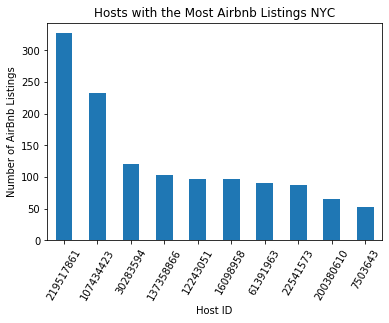

,Total_Listings
Host_ID,
219517861,327
107434423,232
30283594,121
137358866,103
12243051,96
16098958,96
61391963,91
22541573,87
200380610,65


In [64]:
top_hosts = hosts_count_df.nlargest(10, 'Total_Listings')
top_hosts['Total_Listings'].plot(kind='bar')
plt.title('Hosts with the Most Airbnb Listings NYC')
plt.xlabel('Host ID')
plt.ylabel('Number of AirBnb Listings')
plt.xticks(rotation = 60)
plt.show()
hosts_count_df.head(10)

The top 10 hosts in terms of amount of listings all have more than 50 listings with our top 4 hosts topping the 100 listing mark

Let's also look beyond our top 10 hosts at what percentage of the hosts are multi-listing hosts and how many Airbnb's are listed by multi-listing hosts

In [65]:
multi_unit_hosts = hosts_count_df.loc[hosts_count_df['Total_Listings'] > 1, 'Total_Listings'].count()
listings_multi_unit_owners = hosts_count_df.loc[hosts_count_df['Total_Listings'] > 1, 'Total_Listings'].sum()
total_num_hosts = len(hosts_count_df.index)
total_number_listings = len(data.index)
percentage_multi_unit_hosts = multi_unit_hosts / total_num_hosts * 100
percentage_units_multi_unit_hosts = listings_multi_unit_owners / total_number_listings * 100
number_units_per_host = total_number_listings / total_num_hosts
number_units_per_multi_unit_host = listings_multi_unit_owners / multi_unit_hosts

owner_df = pd.DataFrame(
    {'Multi Unit Hosts': multi_unit_hosts,
     'Total Hosts ': total_num_hosts,
     'Percentage Multi Unit Hosts': percentage_multi_unit_hosts,
     'Total Listings Under Multi Unit Hosts': listings_multi_unit_owners,
     'Total Listings': total_number_listings,
     'Percentage Listings from Multi Unit Hosts': percentage_units_multi_unit_hosts,
     'Average Listings per Host' : number_units_per_host,
     'Average Listings Per Multi Unit Host' : number_units_per_multi_unit_host},index=[0] 
)

multi_unit_hosts
listings_multi_unit_owners
total_num_hosts
total_number_listings
percentage_multi_unit_hosts
percentage_units_multi_unit_hosts
owner_df.round(2)


,Multi Unit Hosts,Total Hosts,Percentage Multi Unit Hosts,Total Listings Under Multi Unit Hosts,Total Listings,Percentage Listings from Multi Unit Hosts,Average Listings per Host,Average Listings Per Multi Unit Host
0,5153,37455,13.76,16582,48884,33.92,1.31,3.22


#### A quick summary of the above metrics:

From the NY Airbnb data set for 2019, a total of 5153 hosts listed more than one property, while 32,302 hosts listed a single property.The 5153 hosts that listed more than one property accounted for 16582 of the 48884 total listings made in 2019. 

The top or best, 13.76% of hosts accounted for 33.92% of all 2019 Airbnb listings made in New York. These top 13.76% or 5153 hosts averaged 3.22 listings each.

### Conclusion

***

Now that we've concluded our data exploration of the 2019 Airbnb NYC data set we will highlight some of the takeaways and insights we gained  

We first began looking into the geographical distribution of the listings. We found that despite the data set containing five boroughs under the categorical feature of 'neighbourhood_group', 97% of all listings resided within 3 of the 5 NYC boroughs (Manhattan, Brooklyn and Queens). We examined the average cost of each accommodation type across all listing and found that the price to rent an entire home or apartment is approximatly double the per night price of a shared room and triple the price of a shared room. 

### <font color = 'gray'>

Further Work:

Finalize Conclusion Section

Short Term Rentals: Look into the minimum number of nights for the listings. From the minimum number of nights we can bucket them and plot the distribution

Improve the Top Host section to break down the distribution of the listing types each of the top host has. Do hosts tend to own the same type of listings?

Improve the multi listing host section to bucket the number of listings and plot distribution

Take the listings from each of the 221 neighbourhoods, calculate the mean price per night for each of these neighbourhoods and place a marker at the center of the neighbourhood indicating the mean price per night of an accommodation

Fix the most and least expensive neighbourhoods, since we filtered the data across neighbourhood groups we might consider letting neighbourhoods with less than 5 listings qualify as if the neighbourhood contained a listing that was considered an outlier across the neighbourhood group, the listing would have already been dropped